In [38]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import seaborn as sns
# sns.set(color_codes = True)
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 8)

In [39]:
jtplot.style(theme='monokai')

# Data Importing and Cleaning

### Chart Data

In [40]:
chart_df = pd.read_csv('../data/all_charts.csv')
chart_df = chart_df[['chartDate', 
                     'title', 
                     'artist', 
                     'peakPos', 
                     'lastPos',
                     'weeks',
                     'rank',
                     'change',
                     'spotifyID']]
chart_df['chartDate'] = pd.to_datetime(chart_df[('chartDate')])
chart_df['year'] = chart_df['chartDate'].dt.year
chart_df['month'] = chart_df['chartDate'].dt.month
chart_df['decade'] = (chart_df.chartDate.dt.year//10)*10
chart_df['rank_weight'] = 101 - chart_df['rank'] 

/Users/AndrewKraemer/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (18,19,20,21,22,23,24,25,26,27,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [41]:
# Only keep top 10
chart_df = chart_df[chart_df['rank'] < 11]

In [42]:
##### wh check
# chart_df[(chart_df['year'] == 1993) & (chart_df['month'] == 1) & (chart_df['rank'] == 1)]#[['chartDate', 'title', 'artist', 'rank', 'month', 'year']].sort_values('chartDate')

### Spotify Data

In [43]:
spotify_df = pd.read_csv('../data/spotify_data.csv')
spotify_df = spotify_df.drop_duplicates(subset = 'track_uri') # remove one spotify dup
spotify_df['maj_minor'] = spotify_df['key_mode'].str.split(' ', 1).str[1]

### Lyrics Data

#### Import and clean data

In [44]:
lyrics_df = pd.read_csv('../data/lyrics.csv')
lyrics_df = lyrics_df[lyrics_df['Source'].notnull()] # remove songs without lyrics
lyrics_df = lyrics_df.drop_duplicates(subset = 'spotifyID')

In [45]:
# Create TextBlob object. Extract polarity score
from textblob import TextBlob
lyrics_df['tb_obj'] = lyrics_df['Lyrics'].apply(lambda lyric: TextBlob(lyric)) # takes a bit to run
lyrics_df['polarity'] = lyrics_df['tb_obj'].apply(lambda tb_obj: tb_obj.sentiment.polarity)
lyrics_df['polarity'] = lyrics_df['polarity'].apply(lambda x: (x + 1) / 2) # converts (-1,1) score to (0,1)

#### Word Analysis

In [46]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english', max_features=5000)
vectorized = cv.fit_transform(lyrics_df['Lyrics'])
words = cv.get_feature_names()

word_counts = pd.DataFrame.from_dict({word: vectorized.getcol(idx).sum() for word, idx in cv.vocabulary_.items()}, orient='index').reset_index()
word_counts.columns = ['word', 'count'] # rename columns

/Users/AndrewKraemer/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


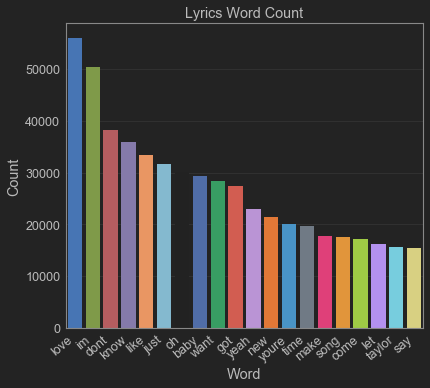

In [47]:
top_words = word_counts.sort_values('count', ascending = False).head(20)
sns.barplot(x = 'word', 
            y = 'count', data = top_words )
plt.xlabel('Word')
plt.ylabel('Count')
plt.xticks(rotation=40, ha = 'right')
plt.title('Lyrics Word Count')
plt.show()

### Join Data

In [48]:
df = pd.merge(chart_df, spotify_df, left_on='spotifyID', right_on = 'track_uri', how='inner')
df = pd.merge(df, lyrics_df, left_on='spotifyID', right_on = 'spotifyID', how='inner')

In [49]:
df[(df['month'] == 11) & (df['year'] == 2004) & (df['rank'] == 1)]
# chart_df[(chart_df['month'] == 11) & (chart_df['year'] == 2004) & (chart_df['rank'] == 1)]

,chartDate,title,artist,peakPos,lastPos,weeks,rank,change,spotifyID,year,...,duration_ms,time_signature,key_mode,maj_minor,Song,Artist,Lyrics,Source,tb_obj,polarity
20521,2004-11-06,My Boo,Usher And Alicia Keys,1,1,9,1,0,68vgtRHr7iZHpzGpon6Jlo,2004,...,223440.0,4,F major,major,my boo,usher alicia keys,theres always that one person that will always...,2.0,"(t, h, e, r, e, s, , a, l, w, a, y, s, , t, ...",0.528676
20522,2004-11-13,My Boo,Usher And Alicia Keys,1,1,10,1,0,68vgtRHr7iZHpzGpon6Jlo,2004,...,223440.0,4,F major,major,my boo,usher alicia keys,theres always that one person that will always...,2.0,"(t, h, e, r, e, s, , a, l, w, a, y, s, , t, ...",0.528676
20523,2004-11-20,My Boo,Usher And Alicia Keys,1,1,11,1,0,68vgtRHr7iZHpzGpon6Jlo,2004,...,223440.0,4,F major,major,my boo,usher alicia keys,theres always that one person that will always...,2.0,"(t, h, e, r, e, s, , a, l, w, a, y, s, , t, ...",0.528676
20524,2004-11-27,My Boo,Usher And Alicia Keys,1,1,12,1,0,68vgtRHr7iZHpzGpon6Jlo,2004,...,223440.0,4,F major,major,my boo,usher alicia keys,theres always that one person that will always...,2.0,"(t, h, e, r, e, s, , a, l, w, a, y, s, , t, ...",0.528676


#### Analysis

In [50]:
import operator
def quick_filter(df, bort, peak_pos_thresh = 5):        
    """
    Function quickly subsets the data for quick data searches & avoids making temporary dataframes
    It's not perfect but it's quick and helpful
    """
    spot_flds = ['chartDate', 'title', 'artist', 'peakPos', 'valence', 'energy', 'polarity', 'happy_index']
    return df[bort & (df['peakPos'] < peak_pos_thresh)][spot_flds].drop_duplicates(subset = ['title', 'artist'])

In [51]:
# Examples for valence v energy plot below

# quick_filter(df, (df['valence'] < .2) & (df['energy'] < .2))
# Can You Feel The Love Tonight by Elton John (142471)

# quick_filter(df, (df['valence'] > .8) & (df['energy'] < .4))
# Bang Bang (My Baby Shot Me Down) nancy sinatra

# quick_filter(df, (df['valence'] > .8) & (df['energy'] > .8))
# surfin usa beach boys, splish splash, if I had a hammer, timber pitbull + kesha, hey yah outcast

# quick_filter(df, (df['valence'] < .3) & (df['energy'] > .8))
# Like A Prayer	Madonna, My Sacrifice Creed

In [52]:
# create of energy quadrants
he_hv = df[(df['energy'] > .5) & (df['valence'] > .5) ].shape[0]
he_lv = df[(df['energy'] > .5) & (df['valence'] <= .5)].shape[0]
le_lv = df[(df['energy'] <= .5) &(df['valence'] <= .5)].shape[0]
le_hv = df[(df['energy'] <= .5) & (df['valence'] > .5)].shape[0]

[cnt / df.shape[0] for cnt in [he_hv, he_lv, le_lv, le_hv]]
def pretty_pct(quad_count, df = df):
    pct = quad_count / df.shape[0]
    pct = round(pct*100,2)
    return  str(pct) + '%'
pretty_pct(he_hv)

'55.78%'

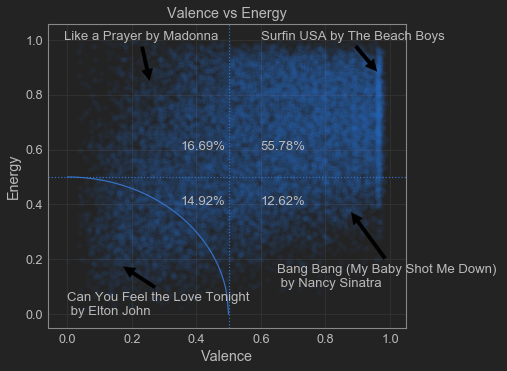

In [53]:
# Show off the differences 
plt.scatter(spotify_df['valence'], spotify_df['energy'], alpha = .05)
plt.title('Valence vs Energy')
plt.xlabel('Valence')
plt.ylabel('Energy')
plt.axvline(x=0.5, ls = 'dotted')
plt.axhline(y=0.5, ls = 'dotted')

the_x = np.linspace(0, .5, 100)
the_y = (.25 - the_x**2)**(1/2)
plt.plot(the_x, the_y)

plt.annotate('Surfin USA by The Beach Boys', xy=(0.964, 0.878), xytext = (.6,1), 
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(pretty_pct(he_hv), xy=(.6,.6))

plt.annotate('Bang Bang (My Baby Shot Me Down) \n by Nancy Sinatra', xy=(0.873, 0.382), xytext = (.65,.1), 
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(pretty_pct(le_hv), xy=(.6,.4))

plt.annotate('Can You Feel the Love Tonight \n by Elton John', xy=(0.1670, 0.1790), xytext = (0,0), 
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(pretty_pct(le_lv), xy=(.35,.4))

plt.annotate('Like a Prayer by Madonna', xy=(0.2570, 0.842), xytext = (-.01,1), 
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(pretty_pct(he_lv), xy=(.35,.6))

plt.show()

In [54]:
# quick_filter(df, (df['polarity'] < .4))
# Bridge Over Troubled Water \n by Simon & Garfunkel

# quick_filter(df, (df['polarity'] > .65))
# You're Beautiful by James Blunt

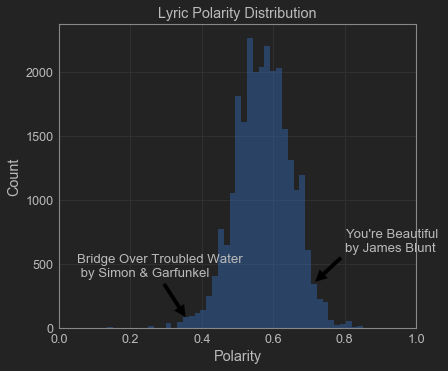

In [55]:
sns.distplot(df['polarity'], kde = False)
plt.title('Lyric Polarity Distribution')
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.xlim(0, 1)

plt.annotate('Bridge Over Troubled Water \n by Simon & Garfunkel', 
             xy=(0.358322, 70), 
             xytext = (.05, 400), 
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.annotate("You're Beautiful \nby James Blunt", 
             xy=(0.712690, 350), 
             xytext = (.8, 600), 
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

Create Happy_Index by combining *valence* and *energy* from Spotify with the *polarity* of the Lyrics -- while normalizing. 

In [56]:
from sklearn.metrics.pairwise import euclidean_distances
coord = df['coord'] =[[df['valence'].iloc[i], df['energy'].iloc[i]] for i in range(df.shape[0])]
df['euclidean_dist'] = euclidean_distances(coord, [[0, 0]])

df['euc_dist_normed'] = df['euclidean_dist'] / (2**(1/2)) # euclidian dist between (0,0) & (1,1)
df['happy_index'] = (df['euc_dist_normed'] + df['polarity'])/2
df['happy_flag'] = np.where(df['happy_index'] > .5, 1, 0)

In [57]:
# quick_filter(df, (df['happy_index'] < .4))
# Without You \n by Harry Nilsson 0.396429

# quick_filter(df, (df['happy_index'] > .8))
# I Feel Fine by The Beatles  0.817876

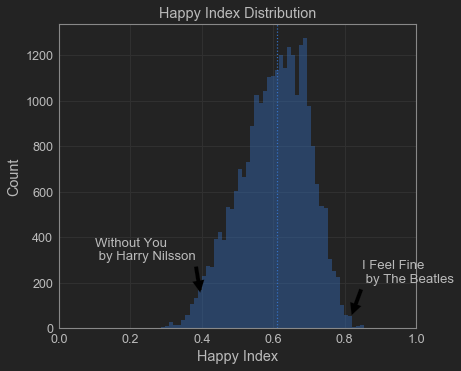

In [58]:
sns.distplot(df['happy_index'], kde = False)
plt.title('Happy Index Distribution')
plt.xlabel('Happy Index')
plt.ylabel('Count')
plt.xlim(0, 1)
plt.axvline(x = df['happy_index'].median(), ls = 'dotted') # add vertical line for the median

plt.annotate('Without You \n by Harry Nilsson', 
             xy=(0.396429, 150), 
             xytext = (.1, 300), 
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.annotate("I Feel Fine \n by The Beatles", 
             xy=(0.817876,50), 
             xytext = (.85, 200), 
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

#### Over Time

/Users/AndrewKraemer/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


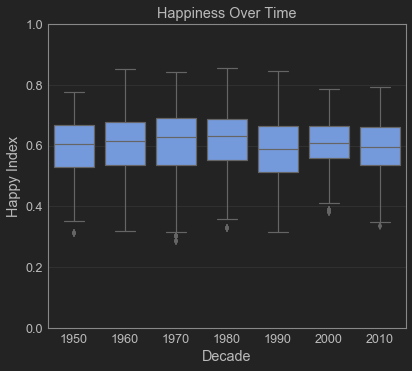

In [59]:
sns.boxplot(x = 'decade', y = 'happy_index', data = df,
            color = '#6495ED')
plt.title('Happiness Over Time')
plt.xlabel('Decade')
plt.ylabel('Happy Index')
plt.ylim(0, 1)
plt.show()

#### Missing Data

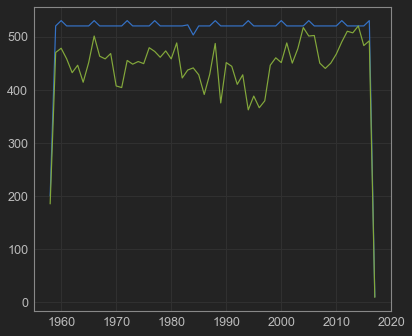

All chart totals: 30455 
Merged Dataset: 26419 
Percent Coverage: 86.75%


In [60]:
chart_year = chart_df.groupby('year')['rank'].count().reset_index(name = 'count')
df_year = df.groupby('year')['rank'].count().reset_index(name = 'count')
plt.plot(chart_year['year'], chart_year['count'])
plt.plot(df_year['year'], df_year['count'])
plt.show()
print('All chart totals: ' + str(chart_year['count'].sum()), 
      '\nMerged Dataset: ' + str(df_year['count'].sum()),
      '\nPercent Coverage: ' + str(round(df_year['count'].sum() / chart_year['count'].sum()*100,2)) + '%')

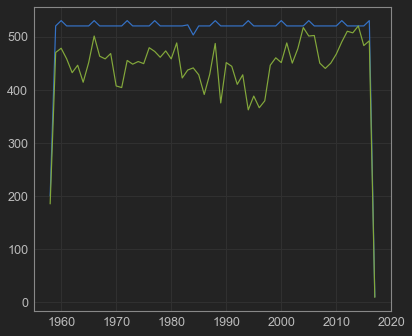

All chart totals: 30455 
Merged Dataset: 26419 
Percent Coverage: 86.75%


In [61]:
chart_year_10 = chart_df[chart_df['rank'] < 11].groupby('year')['rank'].count().reset_index(name = 'count')
df_year_10 = df[df['rank'] < 11].groupby('year')['rank'].count().reset_index(name = 'count')
plt.plot(chart_year_10['year'], chart_year_10['count'])
plt.plot(df_year_10['year'], df_year_10['count'])
plt.show()
print('All chart totals: ' + str(chart_year_10['count'].sum()), 
      '\nMerged Dataset: ' + str(df_year_10['count'].sum()),
      '\nPercent Coverage: ' + str(round(df_year_10['count'].sum() / chart_year_10['count'].sum()*100,2)) + '%')

## add in external predictors

Group Bilboard to Month

In [62]:
df_month = df.groupby(['year', 'month', 'decade'])[['happy_index', 'valence', 'energy', 'polarity']].mean().reset_index()

In [63]:
# multiple aggregations. Drives me crazy that this is the best way to do this
def compute_metrics(x):
    result = {'happy_index_min': x['happy_index'].min(), 
              'happy_index_mean': x['happy_index'].mean(),
              'count': x['happy_index'].count()}
    return pd.Series(result)
df_month = df.groupby(['year', 'month', 'decade']).apply(compute_metrics).reset_index()

In [64]:
df_month['dates'] = [pd.to_datetime(str(a)+str(b)+str(c), format='%m%d%Y') for a,b,c in zip(df_month.month, np.ones(df_month.shape[0]).astype(int), df_month.year)]
df_month_date = df_month.set_index('dates')

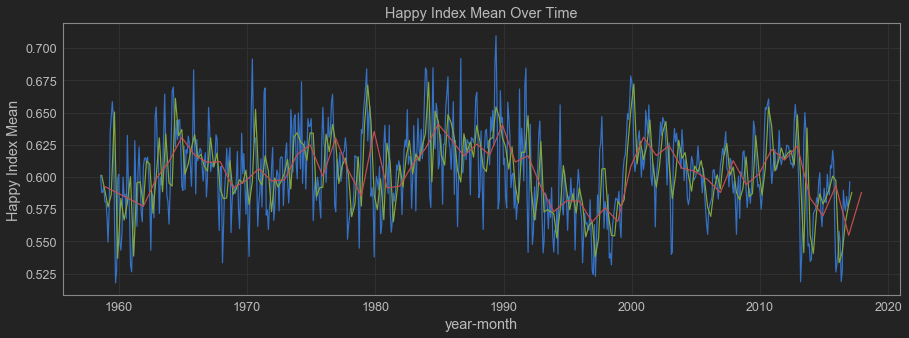

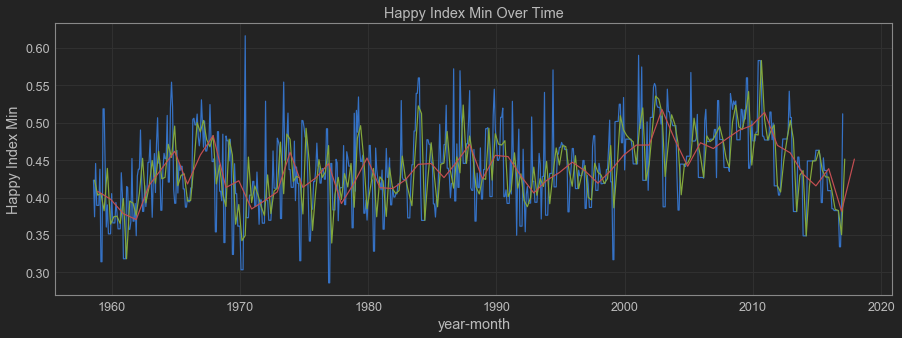

In [65]:
plt.subplots(figsize = (15,5))
plt.plot(df_month_date['happy_index_mean'])
plt.plot(df_month_date.resample('Q-NOV')['happy_index_mean'].mean())
plt.plot(df_month_date.resample('A-NOV')['happy_index_mean'].mean())

plt.title('Happy Index Mean Over Time')
plt.xlabel('year-month')
plt.ylabel('Happy Index Mean')
# plt.ylim(0, 1)
plt.show()

plt.subplots(figsize = (15,5))
plt.plot(df_month_date['happy_index_min'])
plt.plot(df_month_date.resample('Q-NOV')['happy_index_min'].mean())
plt.plot(df_month_date.resample('A-NOV')['happy_index_min'].mean())

plt.title('Happy Index Min Over Time')
plt.xlabel('year-month')
plt.ylabel('Happy Index Min')
# plt.ylim(0, 1)
plt.show()

Import SnP and clean

In [66]:
snp_df = pd.read_csv('../data/daily_snp500.csv')
snp_df['Date'] = pd.to_datetime(snp_df[('Date')])
snp_df['year'] = snp_df['Date'].dt.year
snp_df['month'] = snp_df['Date'].dt.month
snp_df['Mid'] = (snp_df['High'] + snp_df['Low'])/2

In [67]:
# aggregate snp
def snp_agg(x):
    result = {'snp_high': x['High'].max(), 
              'snp_low': x['Low'].min(),
              'snp_mid': x['Mid'].mean(),
              'snp_vol': x['Volume'].sum()}
    return pd.Series(result)

snp_month_df = snp_df.groupby(['year', 'month']).apply(snp_agg).reset_index()

In [68]:
# merge snp with music data
df_month = pd.merge(df_month, snp_month_df)

Import CCI

In [69]:
# import consumer confidence index
cci_df = pd.read_csv('../data/cci.csv')
# only keep important information
cci_df = cci_df[cci_df['LOCATION'] == 'USA'][['TIME', 'Value']]
cci_df['TIME'] = pd.to_datetime(cci_df['TIME'])
cci_df['month'] = cci_df['TIME'].dt.month
cci_df['year'] = cci_df['TIME'].dt.year
cci_df = cci_df.rename(index=str, columns = {'Value': 'cci_value'})
cci_df = cci_df.drop('TIME', axis = 1)

In [70]:
# merge cci with music data
df_month = pd.merge(df_month, cci_df)

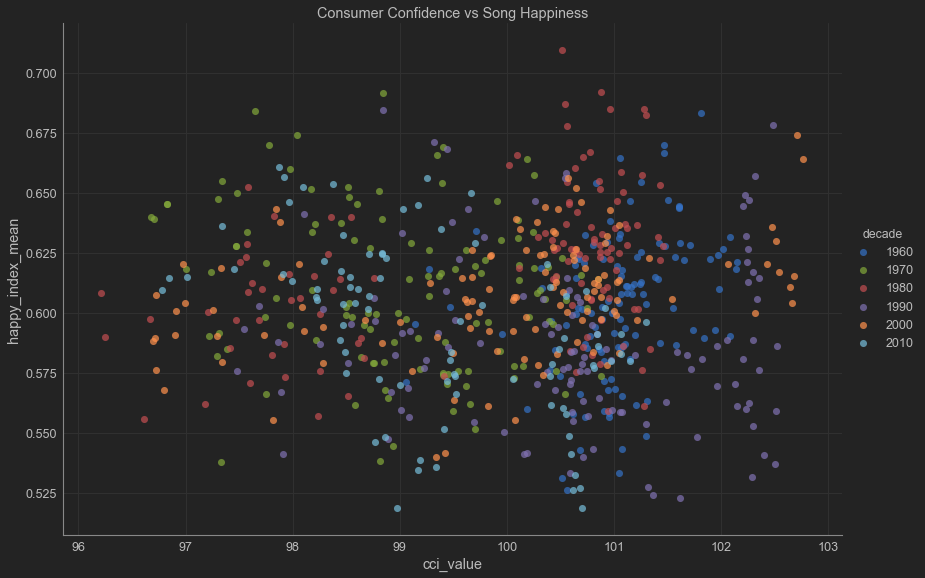

In [71]:
# sns.regplot(x="cci_value", y="happy_index", data=df_month)
sns.lmplot(x = "cci_value", 
           y = "happy_index_mean", 
           data = df_month,
           fit_reg = False, hue = 'decade', size=8, aspect=1.5, scatter_kws={'alpha':0.7,"s": 50})
plt.title('Consumer Confidence vs Song Happiness')
plt.show()

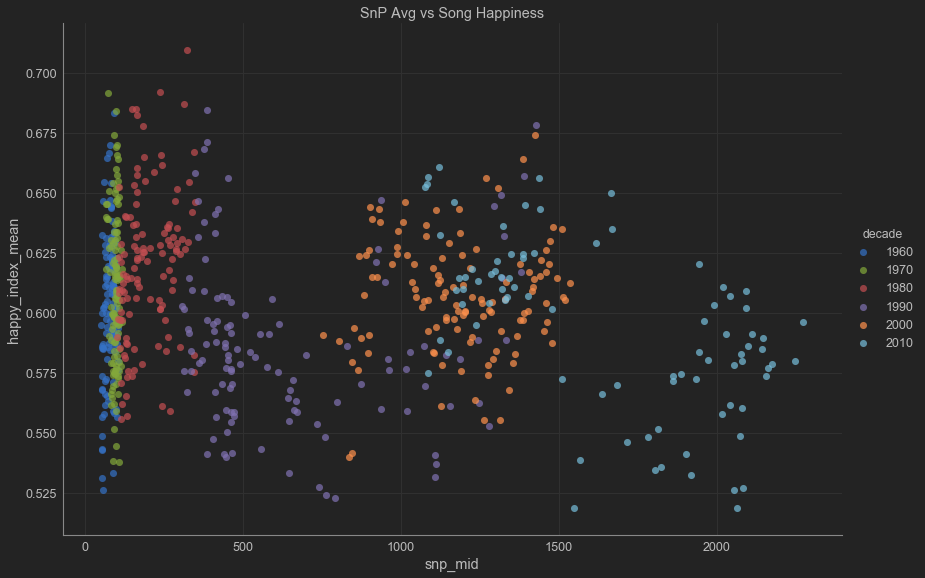

In [72]:
sns.lmplot(x="snp_mid", 
           y="happy_index_mean", 
           data=df_month, 
           fit_reg = False, hue = 'decade', size=8, aspect=1.5, scatter_kws={'alpha':0.7,"s": 50})

plt.title('SnP Avg vs Song Happiness')
plt.show()

In [73]:
# filter & agg for unhappy tracks that made #1 billboard
flag_df = df[(df['happy_flag'] == 0) & (df['rank'] == 1)]\
              .groupby(['year', 'month'])\
              .apply(compute_metrics).reset_index()

In [74]:
# convert year and month to datetime, create index, fill in months with no sad songs with 0
flag_df['dates'] = [pd.to_datetime(str(a)+str(b)+str(c), format='%m%d%Y') for a,b,c in zip(flag_df.month, np.ones(flag_df.shape[0]).astype(int), flag_df.year)]
flag_df = flag_df.set_index('dates')
flag_df = flag_df.resample('M').mean().fillna(0)

# create month and year with index b/c fields were filtered  and now have nans
flag_df['month'] = flag_df.index.month
flag_df['year'] = flag_df.index.year

# create flag to show if month had any sad #1 hits
flag_df['sad_hit_flag'] = np.where(flag_df['count'] != 0, 1, 0)

In [75]:
flag_df = pd.merge(flag_df, snp_month_df)
flag_df = pd.merge(flag_df, cci_df)

In [76]:
flag_df['dates'] = [pd.to_datetime(str(a)+str(b)+str(c), format='%m%d%Y') for a,b,c in zip(flag_df.month, np.ones(flag_df.shape[0]).astype(int), flag_df.year)]
flag_df = flag_df.set_index('dates')

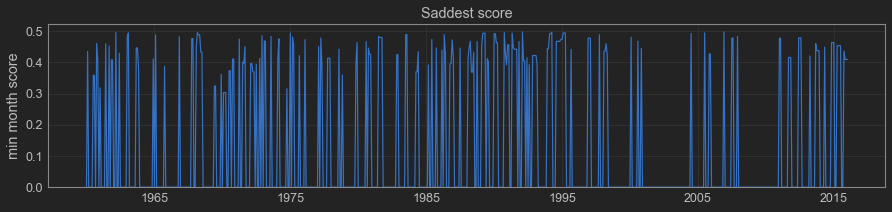

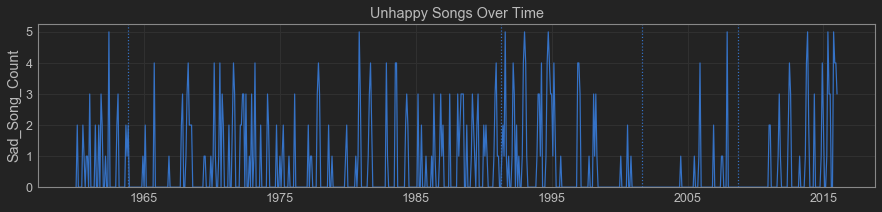

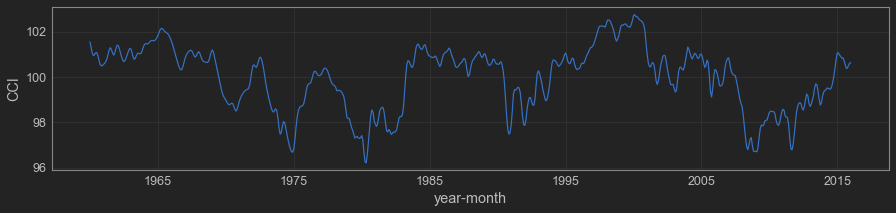

In [77]:
plt.subplots(figsize=(15,3))

plt.plot(flag_df['happy_index_min'])

plt.title('Saddest score')
plt.ylabel('min month score')
plt.ylim(0)
plt.show()

plt.subplots(figsize=(15,3))

plt.plot(flag_df['count'])
plt.axvline(x='1963-10-22', ls = 'dotted') # JFK 
plt.axvline(x='1991-04-09', ls = 'dotted') # berlin wall down 
# plt.axvline(x='1998-09-09', ls = 'dotted') # around the time of bill clinton bj
plt.axvline(x='2001-09-01', ls = 'dotted') # 9/11
plt.axvline(x='2008-09-15', ls = 'dotted') # stock mkt crash


plt.title('Unhappy Songs Over Time')
plt.ylabel('Sad_Song_Count')
plt.ylim(0)
plt.show()

##### Plot 2 #####

plt.subplots(figsize=(15,3))

plt.plot(flag_df['cci_value'])
plt.xlabel('year-month')
plt.ylabel('CCI')
plt.show()

In [78]:
# fit cubic or quartic smoothing
# what is the gradient

In [97]:
from scipy.signal import savgol_filter
# savgol_filter(flag_df['cci_value'], 5, 2)

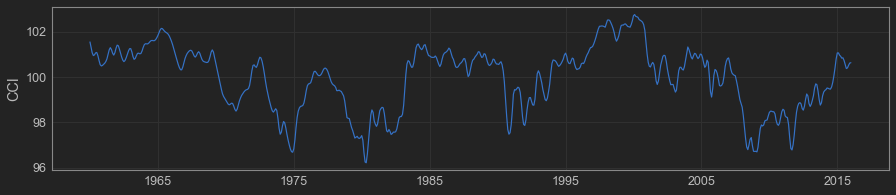

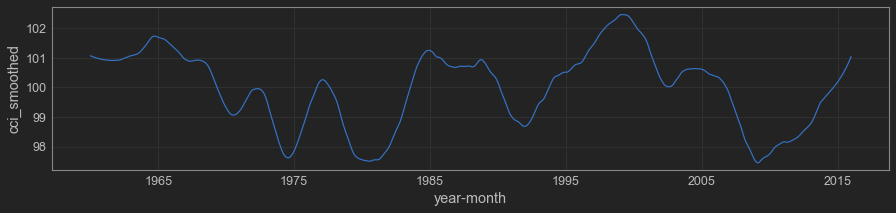

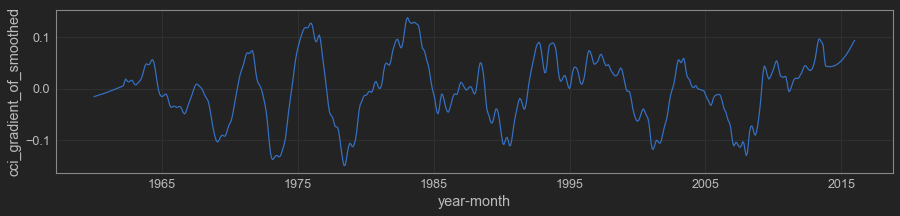

In [120]:
plt.subplots(figsize=(15,3))

plt.plot(flag_df['cci_value'])
plt.ylabel('CCI')
plt.show()

plt.subplots(figsize=(15,3))
flag_df['smooth_cci'] = savgol_filter(flag_df['cci_value'], 55, 3)

plt.plot(flag_df['smooth_cci'])
plt.xlabel('year-month')
plt.ylabel('cci_smoothed')

plt.show()

plt.subplots(figsize=(15,3))
flag_df['cci_gradient_smooth'] = np.gradient(flag_df['smooth_cci'])
plt.plot(flag_df['cci_gradient_smooth'])
plt.xlabel('year-month')
plt.ylabel('cci_gradient_of_smoothed')

plt.show()

In [133]:
flag_df.groupby('sad_hit_flag')['year'].count().reset_index(name = 'count')

,sad_hit_flag,count
0,0,479
1,1,194


In [119]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(flag_df[['cci_gradient_smooth']], flag_df['sad_hit_flag'])
lr.score(flag_df[['cci_gradient_smooth']], flag_df['sad_hit_flag'])

0.71173848439821696

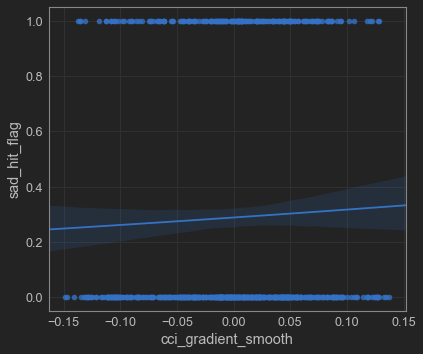

In [122]:
sns.regplot(x = 'cci_gradient_smooth', y = 'sad_hit_flag', data = flag_df, logistic = True)

In [131]:
import statsmodels.api as sm
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
logit = sm.Logit(flag_df['sad_hit_flag'].values, flag_df['cci_gradient_smooth'].values)
result = logit.fit()
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.692573
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  673
Model:                          Logit   Df Residuals:                      672
Method:                           MLE   Df Model:                            0
Date:                Tue, 16 Jan 2018   Pseudo R-squ.:                 -0.1532
Time:                        17:13:18   Log-Likelihood:                -466.10
converged:                       True   LL-Null:                       -404.20
                                        LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.1057      1.259      0.878      0.380      -1.362       3.573


In [345]:
df.drop('tb_obj', axis = 1).to_pickle('../data/df.pkl')

In [366]:
bortbort = df[(df['rank'] == 1) & (df['happy_index'] < .5 )].groupby(['title', 'month', 'year'])['happy_index'].count().reset_index()
bortbort[bortbort['happy_index'] == 5].sort_values('year')

,title,month,year,happy_index
76,I Can't Stop Loving You,6,1962,5
1,"(Everything I Do) I Do It For You (From ""Robin...",8,1991,5
83,"I Will Always Love You (From ""The Bodyguard"")",1,1993,5
90,I ll Make Love To You,10,1994,5
129,No One,12,2007,5
137,Royals,11,2013,5
147,See You Again,5,2015,5
171,The Hills,10,2015,5


As soon as the berlin wall fell down. Mariah Carey told us how she didn't Wanna Cry followed by a month and a half of bryan adams telling us how he'd do anything for us. 

In [363]:
df[(df['year'] == 1991) & (df['rank'] == 1) & (df['happy_index'] < .5 )].groupby(['title', 'month'])['happy_index'].count().reset_index()

,title,month,happy_index
0,"(Everything I Do) I Do It For You (From ""Robin...",7,1
1,"(Everything I Do) I Do It For You (From ""Robin...",8,5
2,"(Everything I Do) I Do It For You (From ""Robin...",9,1
3,I Don t Wanna Cry,5,1
4,I Don t Wanna Cry,6,1
5,More Than Words,6,1
6,The First Time,1,1
7,The First Time,2,1
8,When A Man Loves A Woman,11,1


When will a somber song succeed

5 months smoothing

In [151]:
quick_filter(df, (df['title'] == 'Turn Down For What') & (df['rank'] == 5))

,chartDate,title,artist,peakPos,valence,energy,polarity,happy_index
25134,2014-05-10,Turn Down For What,DJ Snake & Lil Jon,4,0.0815,0.799,0.467901,0.517906


In [152]:
quick_filter(df, df['chartDate'] == '2014-05-10') 

,chartDate,title,artist,peakPos,valence,energy,polarity,happy_index
25009,2014-05-10,Dark Horse,Katy Perry Featuring Juicy J,1,0.3410,0.587,0.658818,0.569422
25057,2014-05-10,Talk Dirty,Jason Derulo Featuring 2 Chainz,3,0.7590,0.652,0.415897,0.561711
25082,2014-05-10,Happy,Pharrell Williams,1,0.8070,0.855,0.748838,0.790092
25101,2014-05-10,All Of Me,John Legend,1,0.3310,0.264,0.598675,0.449027
25134,2014-05-10,Turn Down For What,DJ Snake & Lil Jon,4,0.0815,0.799,0.467901,0.517906
25153,2014-05-10,Fancy,Iggy Azalea Featuring Charli XCX,1,0.3750,0.715,0.565566,0.568232


In [153]:
quick_filter(df, (df['happy_index'] < .5) & (df['rank'] == 1))

,chartDate,title,artist,peakPos,valence,energy,polarity,happy_index
200,1959-01-24,Smoke Gets In Your Eyes,The Platters,1,0.2160,0.2790,0.690909,0.470203
258,1959-02-14,Stagger Lee,Lloyd Price,1,0.5970,0.3990,0.482606,0.495176
505,1959-08-29,The Three Bells,The Browns,1,0.4260,0.1380,0.550316,0.433477
525,1959-09-26,Sleep Walk,Santo & Johnny,1,0.4830,0.2250,0.403896,0.390334
584,1959-11-21,Mr. Blue,The Fleetwoods,1,0.2110,0.0889,0.541194,0.351548
717,1960-02-13,Teen Angel,Mark Dinning,1,0.3490,0.1680,0.596392,0.435138
927,1960-07-23,I'm Sorry,Brenda Lee,1,0.3120,0.2440,0.436341,0.358206
1080,1960-10-29,I Want To Be Wanted,Brenda Lee,1,0.3610,0.1410,0.646822,0.460434
1097,1960-11-19,Georgia On My Mind,Ray Charles,1,0.1970,0.2350,0.593725,0.405280
1145,1961-01-14,Wonderland By Night,Bert Kaempfert And His Orchestra,1,0.1550,0.1150,0.500000,0.318237
